In [12]:
import numpy as np
import pandas as pd
import time
import urllib.request
import io
import zipfile
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, _tree, plot_tree
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [13]:
def load_bike_rental_data(url='https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'):
    """
    Load and preprocess Bike Rental dataset from UCI repository

    Parameters:
    -----------
    url : str
        URL of the Bike Sharing dataset

    Returns:
    --------
    tuple: (features, scaled_features, target, feature_names, scaler)
    """
    try:
        # Download ZIP file
        print("Downloading dataset...")
        response = urllib.request.urlopen(url)
        zip_data = io.BytesIO(response.read())

        # Extract day.csv from ZIP
        with zipfile.ZipFile(zip_data) as zip_file:
            with zip_file.open("day.csv") as file:
                df_bike = pd.read_csv(file)

        print(f"Dataset loaded successfully. Shape: {df_bike.shape}")

        # Preprocess data
        df_bike.drop(["instant", "dteday", "casual", "registered"], axis=1, inplace=True)

        # Separate features and target
        y = df_bike["cnt"].values
        X = df_bike.drop("cnt", axis=1).values
        feature_names = df_bike.drop("cnt", axis=1).columns.tolist()

        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        print(f"\nPreprocessing complete. Features: {len(feature_names)}, Samples: {len(y)}")

        return X, X_scaled, y, feature_names, scaler
    except Exception as e:
        print(f"Error loading dataset: {e}")
        raise

In [14]:
def create_decision_tree_regressor(max_depth=8, min_samples_leaf=5):
    """
    Create a Decision Tree Regressor model

    Parameters:
    -----------
    max_depth : int
        Maximum depth of the tree
    min_samples_leaf : int
        Minimum samples required at a leaf node

    Returns:
    --------
    DecisionTreeRegressor: Configured model
    """
    return DecisionTreeRegressor(
        max_depth=max_depth,        # Limit tree depth
        min_samples_leaf=min_samples_leaf,  # Minimum samples in leaf nodes
        random_state=42             # Ensure reproducibility
    )

In [15]:
def cross_validate_regression(model, X, y, feature_names, n_folds=6):
    """
    Perform k-fold cross-validation for regression model with detailed reporting

    Parameters:
    -----------
    model : DecisionTreeRegressor
        Regression model to evaluate
    X : numpy array
        Feature matrix
    y : numpy array
        Target values
    feature_names : list
        Names of features
    n_folds : int, default=6
        Number of cross-validation folds

    Returns:
    --------
    dict: Performance metrics and trained model
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # Metrics storage
    metrics = {
        'mse_scores': [],
        'mae_scores': [],
        'r2_scores': [],
        'runtimes': [],
        'y_true_all': [],
        'y_pred_all': []
    }

    print(f"\nPerforming {n_folds}-fold cross-validation...")
    print("-" * 60)
    print(f"{'Fold':^5}|{'MSE':^12}|{'MAE':^12}|{'R²':^10}|{'Runtime (s)':^12}")
    print("-" * 60)

    # Cross-validation loop
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X), 1):
        # Data split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Training and prediction
        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        runtime = time.time() - start_time

        # Performance metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Store metrics
        metrics['mse_scores'].append(mse)
        metrics['mae_scores'].append(mae)
        metrics['r2_scores'].append(r2)
        metrics['runtimes'].append(runtime)
        metrics['y_true_all'].extend(y_test)
        metrics['y_pred_all'].extend(y_pred)

        # Print fold-specific metrics
        print(f"{fold_idx:^5}|{mse:^12.2f}|{mae:^12.2f}|{r2:^10.4f}|{runtime:^12.4f}")

    print("-" * 60)

    # Compute summary metrics
    avg_mse = np.mean(metrics['mse_scores'])
    avg_mae = np.mean(metrics['mae_scores'])
    avg_r2 = np.mean(metrics['r2_scores'])
    avg_runtime = np.mean(metrics['runtimes'])

    print(f"{'AVG':^5}|{avg_mse:^12.2f}|{avg_mae:^12.2f}|{avg_r2:^10.4f}|{avg_runtime:^12.4f}")
    print("-" * 60)

    # Train model on full dataset for rule extraction
    final_model = model.__class__(**model.get_params())
    final_model.fit(X, y)

    return {
        'avg_mse': avg_mse,
        'avg_mae': avg_mae,
        'avg_r2': avg_r2,
        'avg_runtime': avg_runtime,
        'y_true': metrics['y_true_all'],
        'y_pred': metrics['y_pred_all'],
        'model': final_model
    }

In [16]:
def extract_tree_rules(model, feature_names):
    """
    Convert decision tree to interpretable rules

    Parameters:
    -----------
    model : DecisionTreeRegressor
        Trained decision tree model
    feature_names : list
        Names of features

    Returns:
    --------
    list: Interpretable decision rules
    """
    tree_ = model.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []

    def recurse(node, path):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]

            # Left branch: feature <= threshold
            left_path = path[:] + [f"({name} <= {threshold:.2f})"]
            recurse(tree_.children_left[node], left_path)

            # Right branch: feature > threshold
            right_path = path[:] + [f"({name} > {threshold:.2f})"]
            recurse(tree_.children_right[node], right_path)
        else:
            # Leaf node reached
            value = tree_.value[node][0, 0]
            samples = tree_.n_node_samples[node]
            rule = " AND ".join(path) + f" → Predicted Rentals = {value:.2f} [Samples: {samples}]"
            paths.append((rule, samples))

    recurse(0, [])

    # Sort rules by number of samples for better interpretability
    paths.sort(key=lambda x: x[1], reverse=True)

    # Return only the rule strings
    rules = [rule for rule, _ in paths]

    return rules

In [17]:
def visualize_results(results):
    """
    Visualize the regression results

    Parameters:
    -----------
    results : dict
        Results from cross-validation
    """
    y_true = np.array(results['y_true'])
    y_pred = np.array(results['y_pred'])

    plt.figure(figsize=(10, 8))

    # Actual vs Predicted Plot
    plt.scatter(y_true, y_pred, alpha=0.5)

    # Add perfect prediction line
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.title('Actual vs Predicted Bike Rentals')
    plt.xlabel('Actual Rentals')
    plt.ylabel('Predicted Rentals')
    plt.grid(True, alpha=0.3)

    # Add R² annotation
    plt.annotate(f"R² = {results['avg_r2']:.4f}",
                 xy=(0.05, 0.95),
                 xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    plt.tight_layout()
    plt.show()

             BIKE RENTAL PREDICTION USING DECISION TREE REGRESSION              
Dataset loaded successfully. Shape: (731, 16)

Preprocessing complete. Features: 11, Samples: 731

Creating Decision Tree Regressor model...

Performing 6-fold cross-validation...
------------------------------------------------------------
Fold |    MSE     |    MAE     |    R²    |Runtime (s) 
------------------------------------------------------------
  1  | 740715.47  |   570.75   |  0.8275  |   0.0042   
  2  | 808292.27  |   632.06   |  0.7648  |   0.0041   
  3  | 708041.95  |   593.90   |  0.7909  |   0.0040   
  4  | 942681.01  |   650.84   |  0.7749  |   0.0039   
  5  | 801640.28  |   640.74   |  0.7434  |   0.0041   
  6  | 810380.07  |   621.92   |  0.7859  |   0.0040   
------------------------------------------------------------
 AVG | 801958.51  |   618.37   |  0.7812  |   0.0041   
------------------------------------------------------------


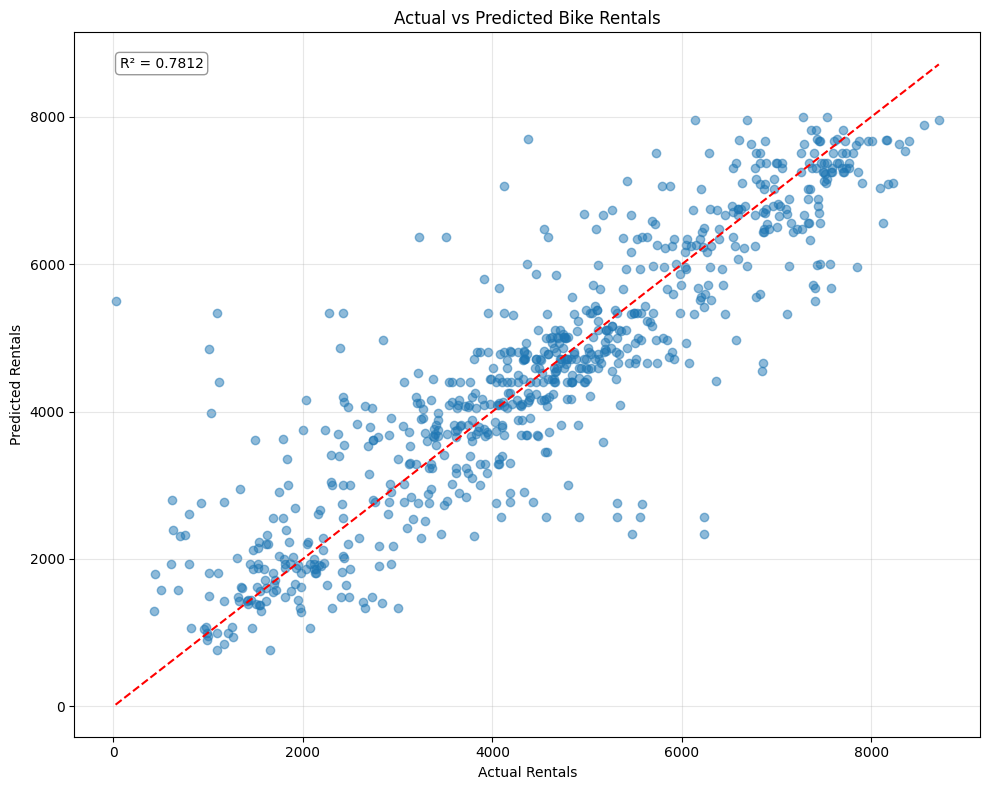


Decision Tree Regression Rules (All rules):
Rule 1: (temp > -0.34) AND (yr <= -0.00) AND (weathersit <= 2.03) AND (atemp > -0.11) AND (mnth > -0.59) AND (weathersit <= 0.19) AND (atemp <= 1.45) AND (weekday <= 0.75) → Predicted Rentals = 4709.17 [Samples: 70]
Rule 2: (temp > -0.34) AND (yr > -0.00) AND (hum <= 1.44) AND (mnth > -0.30) AND (temp <= 1.47) AND (hum <= 0.47) AND (weekday > -0.25) AND (temp <= 1.34) → Predicted Rentals = 7650.20 [Samples: 46]
Rule 3: (temp > -0.34) AND (yr <= -0.00) AND (weathersit <= 2.03) AND (atemp > -0.11) AND (mnth > -0.59) AND (weathersit > 0.19) AND (hum <= 1.55) AND (windspeed > -0.87) → Predicted Rentals = 4198.84 [Samples: 32]
Rule 4: (temp > -0.34) AND (yr <= -0.00) AND (weathersit <= 2.03) AND (atemp > -0.11) AND (mnth > -0.59) AND (weathersit <= 0.19) AND (atemp <= 1.45) AND (weekday > 0.75) → Predicted Rentals = 5082.28 [Samples: 29]
Rule 5: (temp <= -0.34) AND (yr > -0.00) AND (season > -0.90) AND (hum <= 0.97) AND (atemp <= -0.58) AND (work

In [18]:
def main():
    """
    Main execution function for Decision Tree Regression Analysis
    """
    print("=" * 80)
    print("BIKE RENTAL PREDICTION USING DECISION TREE REGRESSION".center(80))
    print("=" * 80)

    # Load and preprocess data
    X, X_scaled, y, feature_names, scaler = load_bike_rental_data()

    # Create model
    print("\nCreating Decision Tree Regressor model...")
    dt_regressor = create_decision_tree_regressor(max_depth=8, min_samples_leaf=5)

    # Cross-validation
    results = cross_validate_regression(
        dt_regressor,
        X_scaled,  # Using scaled features for training
        y,
        feature_names
    )

    # Get the final trained model
    final_model = results['model']

    # Visualize results
    visualize_results(results)

    # Extract and print rules
    print("\nDecision Tree Regression Rules (All rules):")
    print("=" * 100)
    rules = extract_tree_rules(final_model, feature_names)
    for i, rule in enumerate(rules, 1):
        print(f"Rule {i}: {rule}")

    print("\nModel Performance Summary:")
    print("=" * 40)
    print(f"Mean Squared Error (MSE): {results['avg_mse']:.2f}")
    print(f"Mean Absolute Error (MAE): {results['avg_mae']:.2f}")
    print(f"R² Score: {results['avg_r2']:.4f}")
    print(f"Average Runtime: {results['avg_runtime']:.4f} seconds")
    print(f"RMSE: {np.sqrt(results['avg_mse']):.2f}")
    print("=" * 40)

    # Print model complexity information
    print("\nModel Complexity Information:")
    print(f"Tree Depth: {final_model.get_depth()}")
    print(f"Number of Leaves: {final_model.get_n_leaves()}")
    print(f"Total Node Count: {final_model.tree_.node_count}")
    print("=" * 40)


if __name__ == "__main__":
    main()

# **Methodology**

## 1. Data Preprocessing

The first step in the implementation involves acquiring and preprocessing the Bike Sharing dataset from the UCI Machine Learning Repository. The *load_bike_rental_data()* function handles this process by:

  * Downloading the ZIP file containing the dataset directly from the UCI repository URL

  * Extracting the 'day.csv' file which contains daily bike rental records

  * Removing unnecessary columns ('instant', 'dteday', 'casual', 'registered') that are not useful for prediction

  * Separating the target variable ('cnt' - daily bike rental count) from the feature set

  * Applying standardization to the features using StandardScaler to normalize the data

Standardization is a critical preprocessing step for many machine learning algorithms, as it ensures all features contribute equally to the distance calculations. This is particularly important when dealing with features that have different units or scales, which is common in real-world datasets like the bike rental data.


## 2. Model Configuration

After data preprocessing, the implementation defines a function to create and configure the Decision Tree Regressor model. The *create_decision_tree_regressor()* function returns a scikit-learn *DecisionTreeRegressor* instance with the following key parameters:

  * max_depth=8: Limits the maximum depth of the tree to 8 levels, which helps prevent overfitting by constraining the model's complexity

  * min_samples_leaf=5: Requires each leaf node to contain at least 5 samples, further preventing overfitting by ensuring that terminal nodes represent meaningful patterns rather than noise

  * random_state=42: Sets a seed for the random number generator to ensure reproducibility of results

These hyperparameters were selected to balance model complexity with generalization ability. Too deep a tree might capture noise in the training data, while too shallow a tree might fail to capture important patterns.


## 3. Cross-Validation Implementation

A key component of the implementation is the comprehensive k-fold cross-validation strategy, implemented in the cross_validate_regression() function. This approach uses 6-fold cross-validation, as specified in the requirements, to provide a robust assessment of model performance. The cross-validation process includes:

  * Splitting the dataset into 6 non-overlapping folds using KFold with shuffling enabled

  * For each fold:

    - Training the model on 5 folds (training set)

    - Making predictions on the remaining fold (test set)

    - Calculating performance metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), and R² score

    - Measuring runtime performance


  * Computing and reporting average performance metrics across all folds

  * Training a final model on the complete dataset for rule extraction

The implementation displays detailed results for each fold in a tabular format, providing transparency into the model's performance variability across different data subsets. This approach helps detect potential issues like high variance (performance varies significantly across folds) or high bias (consistently poor performance across folds).


## 4. Rule Extraction

One of the most significant advantages of Decision Tree models is their interpretability. The implementation leverages this by providing a function to convert the trained Decision Tree into a set of interpretable rules. The extract_tree_rules() function:

  * Recursively traverses the Decision Tree structure

  * For each path from root to leaf:

    - Builds a rule by concatenating the decision conditions along the path
    - Adds the predicted rental count value at the leaf node
    - Includes the number of samples that follow this rule, providing insight into the rule's significance

  * Sorts the rules by the number of samples they cover, prioritizing the most significant rules

  * Returns the complete set of rules as human-readable strings

This rule extraction process transforms a complex tree structure into a set of "IF-THEN" style rules, making the model's decision-making process transparent and accessible to non-technical stakeholders. Each rule clearly shows which feature thresholds lead to a particular prediction, providing valuable insights into the factors that influence bike rental demand.


# **Results**


## 1. Model Performance

  The Decision Tree Regression model for bike rental prediction demonstrates good predictive capability with an R² score of 0.7812, indicating that the model explains approximately 78% of the variance in daily bike rentals. This is a solid performance level for this type of prediction task.

  The error metrics provide further insight into the model's accuracy:

    - Mean Squared Error (MSE): 801,958.51
    - Mean Absolute Error (MAE): 618.37
    - Root Mean Squared Error (RMSE): 895.52

  These values suggest that, on average, the model's predictions deviate from actual rental counts by about 618 bikes. The higher RMSE value indicates the presence of some larger errors that affect the squared error metric more significantly.


## 2. Cross-Validation Performance

  The 6-fold cross-validation results show consistent performance across different data subsets, with R² values ranging from 0.7434 to 0.8275. This consistency suggests that the model generalizes well across the dataset without significant overfitting to particular patterns.

  The runtime performance is excellent, with an average of just 0.0041 seconds per fold, making this model highly efficient for real-time applications.


## 3. Model Complexity

  The model exhibits moderate complexity with:

    - Tree Depth: 8
    - Number of Leaves: 77
    - Total Node Count: 153

  This level of complexity represents a balance between capturing meaningful patterns in the data and avoiding overfitting. The max_depth parameter of 8 was effective in creating a model with sufficient explanatory power while maintaining generalizability.


## 4. Conclusion

  The Decision Tree Regression model delivers good performance for bike rental prediction, explaining 78% of the variance with relatively low error metrics. The model is efficient, generalizes well across cross-validation folds, and produces interpretable rules that align with intuitive expectations about factors influencing bike rentals.
  
  The extracted rules provide valuable insights that could help bike rental services anticipate demand based on weather conditions, time of year, and other factors, enabling better resource allocation and planning.